Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf 
import datetime as dt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

2025-10-02 05:21:08.645093: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 05:21:09.123841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 05:21:09.408897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759382469.703852     157 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759382469.784223     157 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759382470.405805     157 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Data Loading and EDA

In [2]:
stock= ('TSLA')
start=dt.datetime(2018, 8, 1)
end=dt.datetime.now()

In [3]:
data=yf.download(stock,start=start,end=end)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2018-08-01,20.056000,20.200001,19.533333,19.865999,151941000
2018-08-02,23.302668,23.332666,21.544001,21.896000,348225000
2018-08-03,23.211332,23.666668,22.835333,23.187332,204847500
2018-08-06,22.799334,23.665333,22.788000,23.030666,128464500
2018-08-07,25.304667,25.830667,22.610001,22.922667,463137000
...,...,...,...,...,...
2025-09-25,423.390015,435.350006,419.079987,435.239990,96746400
2025-09-26,440.399994,440.470001,421.019989,428.299988,101628200


In [4]:
data=data.reset_index()

In [5]:
data.isnull().sum()

Price   Ticker
Date              0
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1802 non-null   datetime64[ns]
 1   (Close, TSLA)   1802 non-null   float64       
 2   (High, TSLA)    1802 non-null   float64       
 3   (Low, TSLA)     1802 non-null   float64       
 4   (Open, TSLA)    1802 non-null   float64       
 5   (Volume, TSLA)  1802 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 84.6 KB


In [7]:
data.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
count,1802,1802.000000,1802.000000,1802.000000,1802.000000,1.802000e+03
mean,2022-02-28 16:23:42.419533824,186.822327,191.058280,182.373364,186.842178,1.261711e+08
min,2018-08-01 00:00:00,11.931333,12.445333,11.799333,12.073333,2.940180e+07
25%,2020-05-15 18:00:00,54.641499,56.264167,53.930001,55.297333,7.884532e+07
50%,2022-02-28 12:00:00,209.230003,215.028336,204.795006,209.478333,1.041368e+08
75%,2023-12-12 18:00:00,263.524994,268.977493,258.193344,263.287491,1.458443e+08
max,2025-10-01 00:00:00,479.859985,488.540009,457.510010,475.899994,9.140820e+08
std,NaN,115.387895,118.014509,112.693278,115.486100,7.807923e+07


Visualization

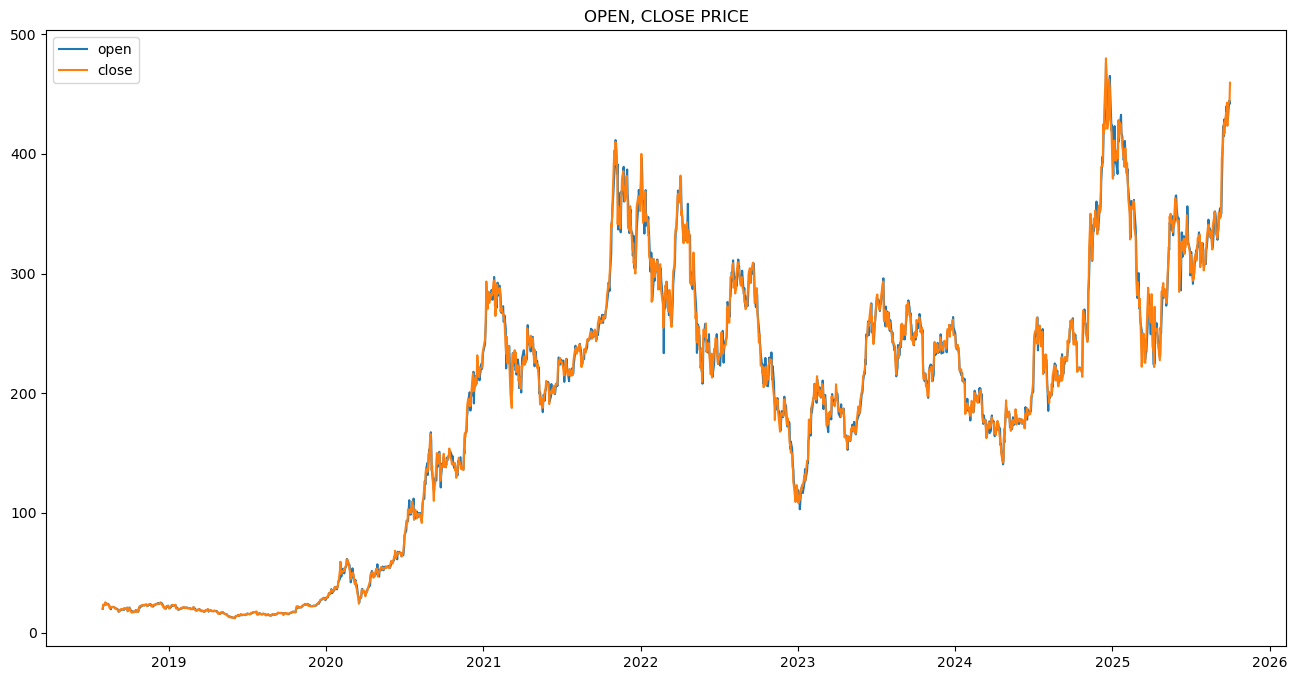

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data['Date'],data['Open'])
plt.plot(data['Date'],data['Close'])
plt.title('OPEN, CLOSE PRICE')
plt.legend(['open','close'])

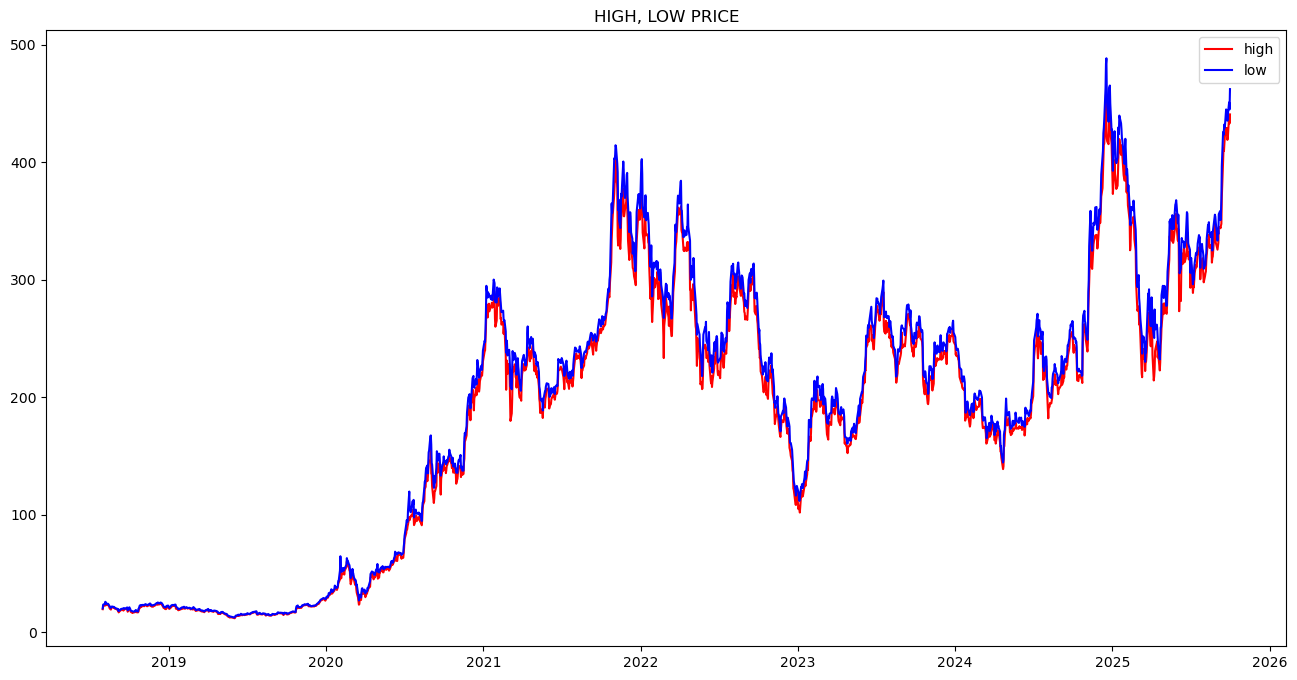

In [9]:
plt.figure(figsize=(16,8))
plt.plot(data['Date'],data['Low'],c='r')
plt.plot(data['Date'],data['High'],c='b')
plt.title('HIGH, LOW PRICE')
plt.legend(['high','low'])

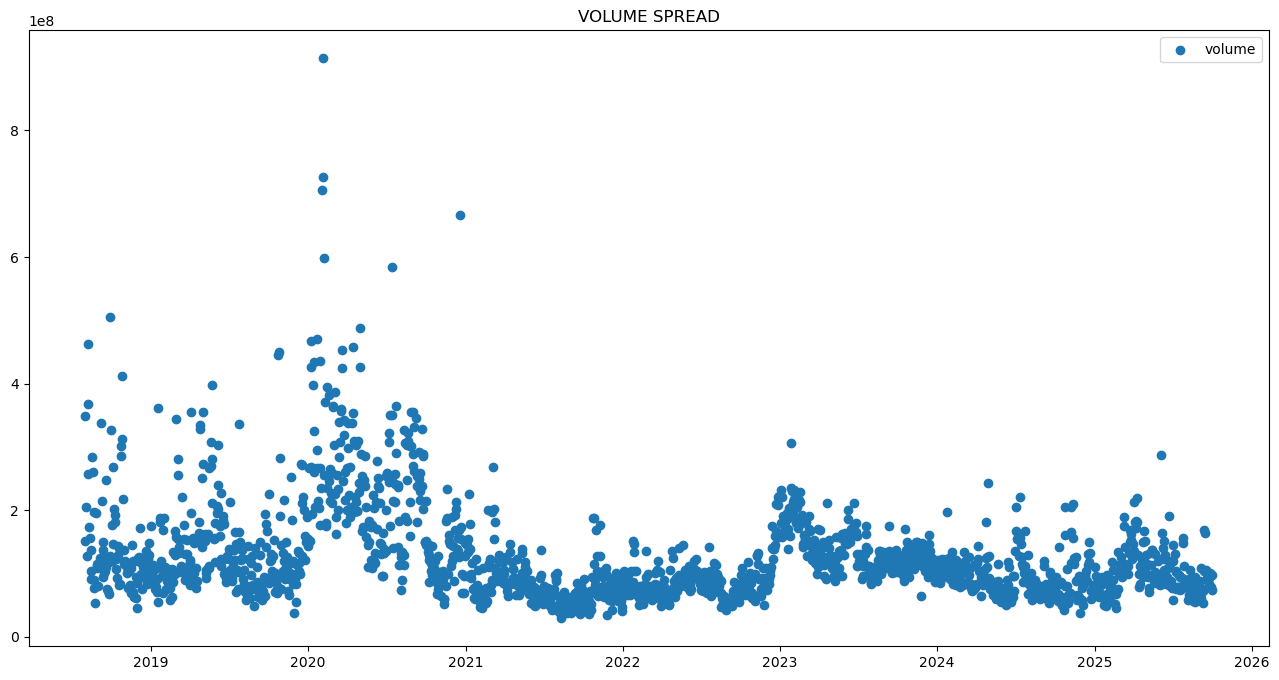

In [10]:
plt.figure(figsize=(16,8))
plt.scatter(data['Date'],data['Volume'])
plt.title('VOLUME SPREAD')
plt.legend(['volume'])

Data Preprocessing

In [11]:
sc=MinMaxScaler(feature_range=(0, 1))

scaled=sc.fit_transform(data['Close'])
scaled


array([[0.01736305],
       [0.02430143],
       [0.02410624],
       ...,
       [0.92167611],
       [0.92490312],
       [0.95640362]])

In [12]:
train_size = int(len(scaled) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

print(train_data.shape,test_data.shape)

(1441, 6) (361, 6)


In [13]:
train_data

Price,Date,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
0,2018-08-01,20.056000,20.200001,19.533333,19.865999,151941000
1,2018-08-02,23.302668,23.332666,21.544001,21.896000,348225000
2,2018-08-03,23.211332,23.666668,22.835333,23.187332,204847500
3,2018-08-06,22.799334,23.665333,22.788000,23.030666,128464500
4,2018-08-07,25.304667,25.830667,22.610001,22.922667,463137000
...,...,...,...,...,...,...
1436,2024-04-17,155.449997,158.330002,153.779999,157.639999,82439700
1437,2024-04-18,149.929993,152.199997,148.699997,151.250000,96098800
1438,2024-04-19,147.050003,150.940002,146.220001,148.970001,87074500


Data Preparation

In [14]:
def create_sequence(data_set,steps):
    x,y=[],[]

    for i in range(60,len(data_set)):
        x.append(data_set.iloc[i-60:i,1])
        y.append(data_set.iloc[i,1])
    return np.array(x),np.array(y)

steps=60

x_train,y_train= create_sequence(train_data,steps)
x_test,y_test=create_sequence(test_data,steps)

In [15]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape,x_test.shape)

(1381, 60, 1) (301, 60, 1)


Model Building

In [ ]:

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()


In [ ]:
lstm_model.evaluate(x_test,y_test)

In [ ]:
lstm_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 15147.6084
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 14894.3486
Epoch 3/20
17/44 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 16141.0244

Model Evaluation

In [20]:
# Get predictions

y_pred = lstm_model.predict(x_test)

# Inverse scaling

y_test = sc.inverse_transform(y_test.reshape(-1, 1))
y_pred = sc.inverse_transform(y_pred)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [25]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics=[['RMSE',rmse],['MAE', mae], ['R2',r2]]
metrics=pd.DataFrame(metrics,columns=['Metrics','Values'])
metrics

,Metrics,Values
0,RMSE,123685.005913
1,MAE,119466.156307
2,R2,-13.912983
